In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from jax import config
config.update('jax_enable_x64', True)
import matplotlib.pyplot as plt
import corner
import pandas as pd
import arviz as az

In [2]:
d = pd.read_csv("t1300g1000f1_m0.0_co1.0.pt", sep='\s+', skiprows=[1])

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/8l/c_0pxd512sd6bbskytr1ccn80000gn/T/ipykernel_54011/4877482.py:1: SyntaxWarning: invalid escape sequence '\s'
  d = pd.read_csv("t1300g1000f1_m0.0_co1.0.pt", sep='\s+', skiprows=[1])


In [3]:
sigma_t = 15

def simulate_data(d, sigma_t):
    x, y = d['T'], d.P
    idx = (1e-3 < d.P) & (d.P < 1e2)
    np.random.seed(123)
    xout, yout = np.array(x[idx])[::2], np.array(y[idx])[::2]
    xobs = np.random.normal(xout, sigma_t)
    return xout, yout, xobs

In [4]:
xtrue, ytrue, xobs = simulate_data(d, sigma_t)

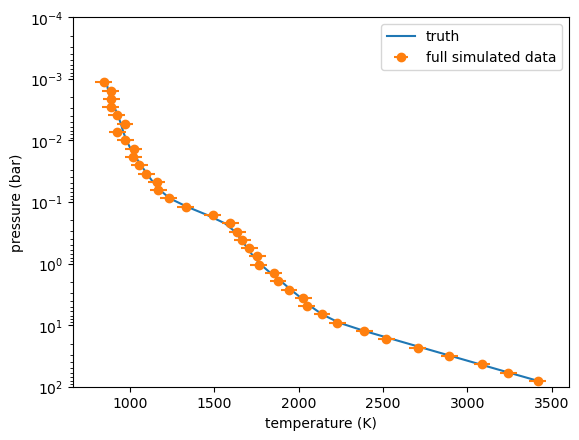

In [5]:
plt.xlabel("temperature (K)")
plt.ylabel("pressure (bar)")
plt.yscale("log")
plt.ylim(1e2, 1e-4)
plt.plot(xtrue, ytrue, '-', label='truth')
plt.errorbar(xobs, ytrue, xerr=50, fmt='o', label='full simulated data')
plt.legend(loc='best');

In [6]:
from contextlib import redirect_stdout

# RBF kernel
def cov_rbf(x, tau, alpha, sigma):
    dx = x[:,None] - x[None, :]
    return alpha**2 * jnp.exp(-0.5 * (dx / tau)**2) + jnp.diag(sigma**2)


def run_mcmc(model, outdir, model_tag=None, nw=1000, ns=1000, **kwargs):
    model_name = model.__name__
    if model_tag is not None:
        model_name += model_tag

    kernel = numpyro.infer.NUTS(model, dense_mass=True)
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
    rng_key = random.PRNGKey(1)
    mcmc.run(rng_key, **kwargs, extra_fields=('potential_energy', 'num_steps', 'adapt_state'))
    mcmc.print_summary()
    with open(f"{outdir}/{model_name}_summary.txt", "w") as f:
        with redirect_stdout(f):
            mcmc.print_summary()

    if 'a' in mcmc.get_samples().keys():
        var_names = ['t0', 'a', 'logalpha', 'logtau', 'logsigma']
    else:
        var_names = ['mu', 'logalpha', 'logtau', 'logsigma']
    az.plot_trace(mcmc, var_names=var_names)
    plt.tight_layout(pad=0.02)
    plt.savefig(f"{outdir}/{model_name}_trace.png")

    idata = az.from_numpyro(mcmc)
    fig = corner.corner(idata, var_names=var_names, show_titles=True)
    plt.savefig(f"{outdir}/{model_name}_corner.png")

    tarr = az.extract(idata, group="posterior")['tarr'].values.T
    plt.figure()
    plt.xlabel("temperature (K)")
    plt.ylabel("pressure (bar)")
    plt.yscale("log")
    plt.ylim(1e2, 1e-3)
    #plt.plot(xtrue, ytrue, '-')
    plt.errorbar(xobs, ytrue, xerr=50, fmt='o', lw=0, mfc='white', color='C0', label='all data')
    plt.errorbar(xobs[data_idx], ytrue[data_idx], xerr=50, fmt='o', lw=0, color='C0', label='data used for inference')
    mu, sig = np.mean(tarr, axis=0), np.std(tarr, axis=0)
    plt.plot(mu, ytrue, '-', color='C1', label='posterior mean & SD')
    plt.fill_betweenx(ytrue, mu-sig, mu+sig, alpha=0.5, color='C1')
    plt.legend(loc='upper right')
    plt.savefig(f"{outdir}/{model_name}_TP.png")

    return idata

In [7]:
data_idx = (0.1 < ytrue) & (ytrue < 5)
outdir = "gp-profile"

### linaer T, constant mean

In [8]:
def model_linear_t(xobs, xerr, yobs, data_idx, xlow=500, xupp=3500, alphamax=1e4):
    N = len(yobs)
    #mu = numpyro.sample("mu", dist.Uniform(xlow, xupp))
    #tarr = numpyro.sample("tarr", dist.Uniform(-jnp.ones(N)*xlow, jnp.ones(N)*xupp))
    mu_base = numpyro.sample("mu_base", dist.Uniform(0,1))
    tarr_base = numpyro.sample("tarr_base", dist.Uniform(jnp.zeros(N),jnp.ones(N)))
    mu = numpyro.deterministic("mu", mu_base * (xupp - xlow) + xlow)
    tarr = numpyro.deterministic("tarr", tarr_base * (xupp - xlow) + xlow)
    numpyro.sample("obs", dist.Normal(tarr[data_idx], xerr[data_idx]), obs=xobs[data_idx])

    logtau = numpyro.sample("logtau", dist.Uniform(jnp.log10(0.3), jnp.log10(30)))
    logalpha = numpyro.sample("logalpha", dist.Uniform(jnp.log10(100), jnp.log10(alphamax)))
    logsigma = numpyro.sample("logsigma", dist.Uniform(jnp.log10(10), jnp.log10(1000)))
    tau = numpyro.deterministic("tau", 10**logtau)
    alpha = numpyro.deterministic("alpha", 10**logalpha)
    sigma = numpyro.deterministic("sigma", 10**logsigma)
    cov_gp = cov_rbf(yobs, tau, alpha, sigma * jnp.ones(N))
    gp = dist.MultivariateNormal(loc=mu*jnp.ones(N), covariance_matrix=cov_gp)
    loglike_gp = numpyro.deterministic("loglike_gp", gp.log_prob(tarr))
    numpyro.factor("loglike", loglike_gp)

sample: 100%|██████████| 2000/2000 [00:45<00:00, 43.80it/s, 127 steps of size 5.42e-02. acc. prob=0.88]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     logalpha      2.72      0.28      2.68      2.30      3.09     70.46      1.01
     logsigma      1.26      0.19      1.22      1.01      1.54     43.06      1.02
       logtau     -0.10      0.32     -0.18     -0.52      0.33     32.22      1.02
      mu_base      0.39      0.14      0.38      0.11      0.58    712.79      1.00
 tarr_base[0]      0.36      0.18      0.35      0.04      0.63     74.05      1.02
 tarr_base[1]      0.36      0.17      0.35      0.04      0.58     77.06      1.02
 tarr_base[2]      0.35      0.16      0.35      0.06      0.57     79.97      1.01
 tarr_base[3]      0.34      0.16      0.33      0.08      0.57     85.95      1.01
 tarr_base[4]      0.33      0.15      0.32      0.07      0.53     92.55      1.01
 tarr_base[5]      0.31      0.14      0.30      0.07      0.51    100.02      1.01
 tarr_base[6]      0.29      0.14      0.27      0.09      0.53    106.84  

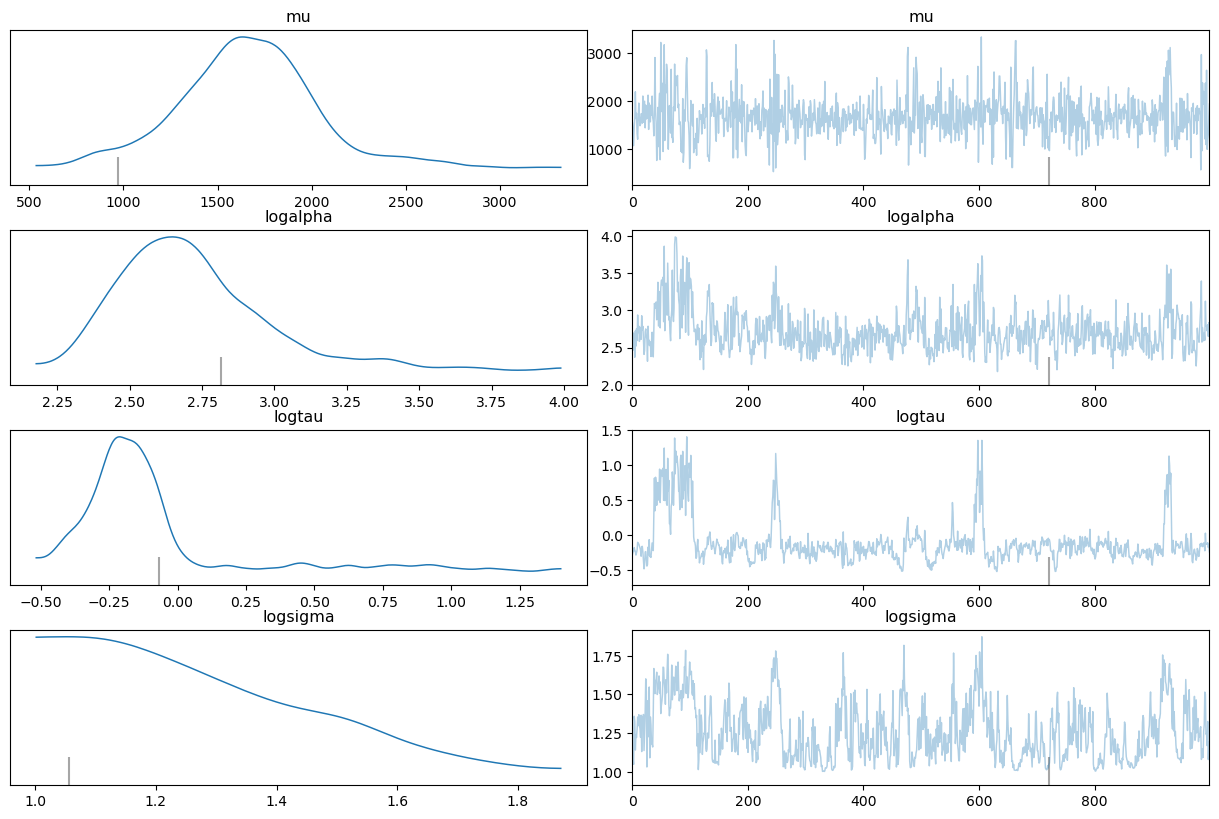

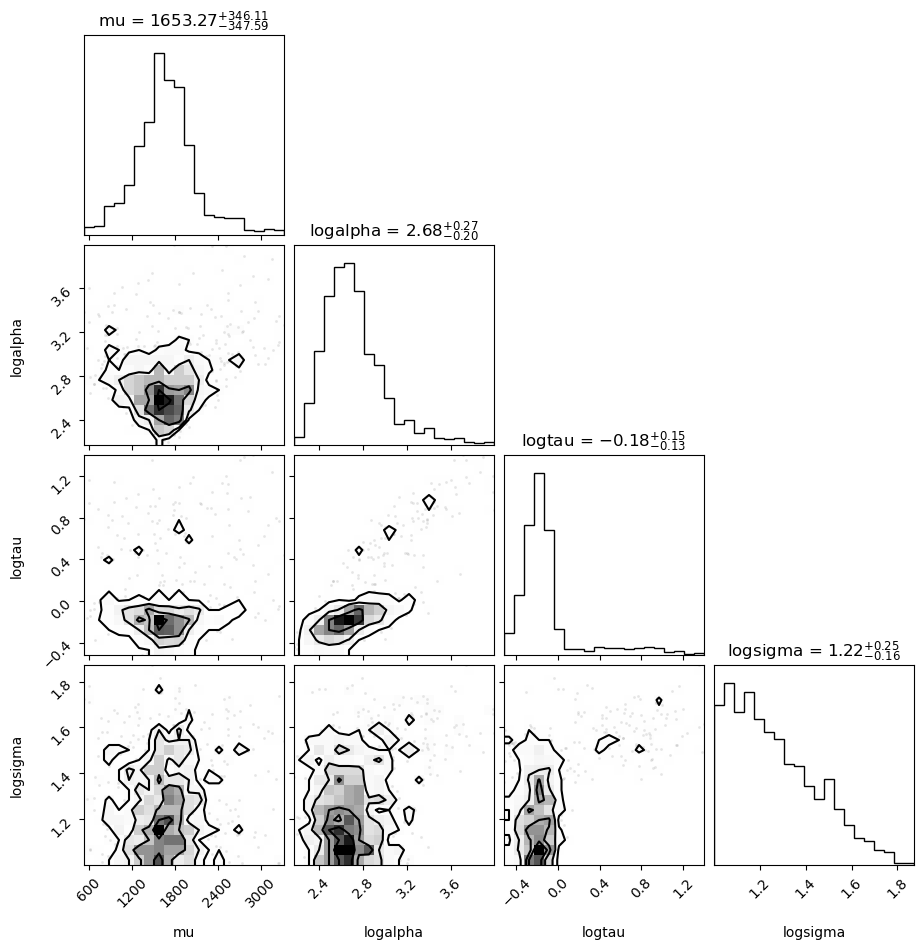

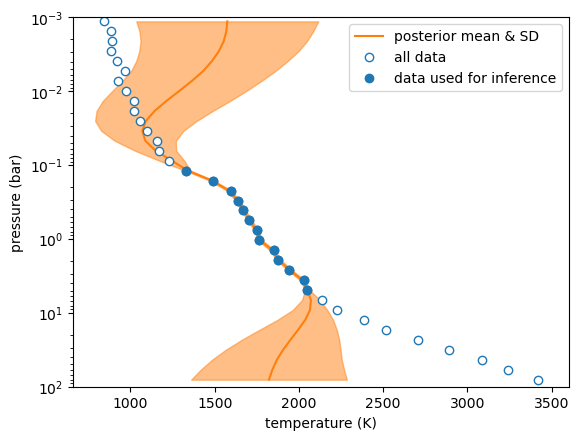

In [10]:
idata_linear_t = run_mcmc(model_linear_t, outdir, xobs=xobs, xerr=jnp.ones_like(xobs)*sigma_t, yobs=np.log10(ytrue), data_idx=data_idx)

sample: 100%|██████████| 2000/2000 [00:51<00:00, 38.49it/s, 63 steps of size 4.53e-02. acc. prob=0.93] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     logalpha      2.83      0.35      2.76      2.27      3.38     50.43      1.02
     logsigma      1.30      0.21      1.26      1.00      1.61     44.10      1.03
       logtau      0.01      0.44     -0.14     -0.52      0.79     31.31      1.04
      mu_base      0.30      0.17      0.26      0.04      0.51    106.79      1.01
 tarr_base[0]      0.22      0.14      0.21      0.00      0.42     73.09      1.03
 tarr_base[1]      0.22      0.14      0.20      0.02      0.42     74.29      1.03
 tarr_base[2]      0.21      0.13      0.20      0.02      0.40     76.69      1.02
 tarr_base[3]      0.20      0.13      0.19      0.01      0.37     79.75      1.02
 tarr_base[4]      0.19      0.12      0.17      0.01      0.36     88.85      1.01
 tarr_base[5]      0.18      0.11      0.16      0.02      0.34    105.70      1.00
 tarr_base[6]      0.17      0.10      0.14      0.01      0.31    120.02  

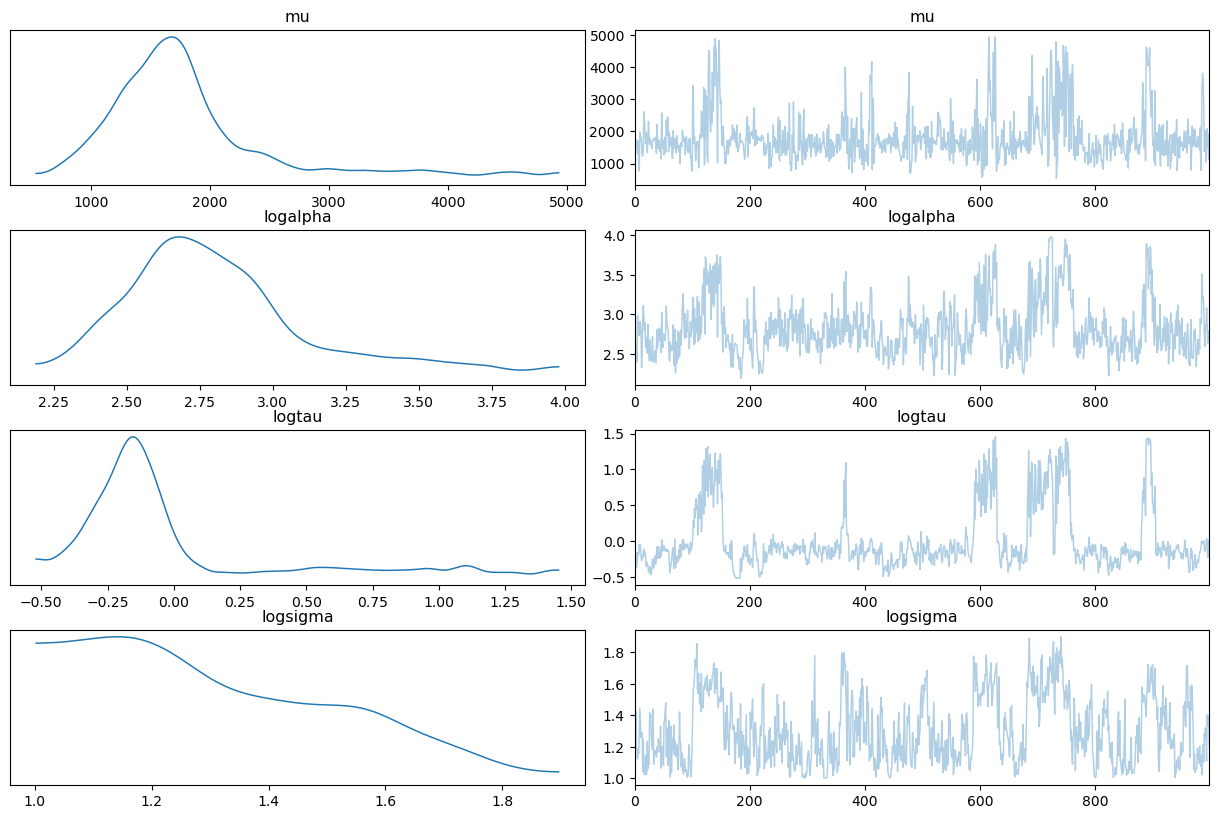

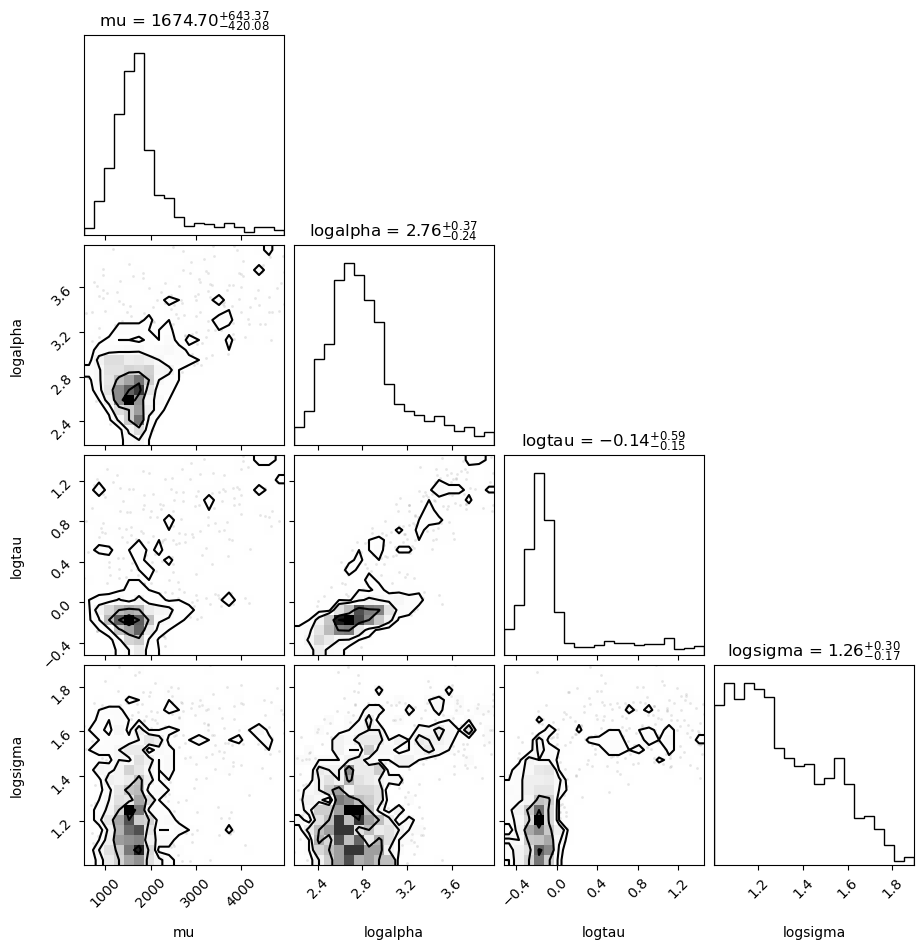

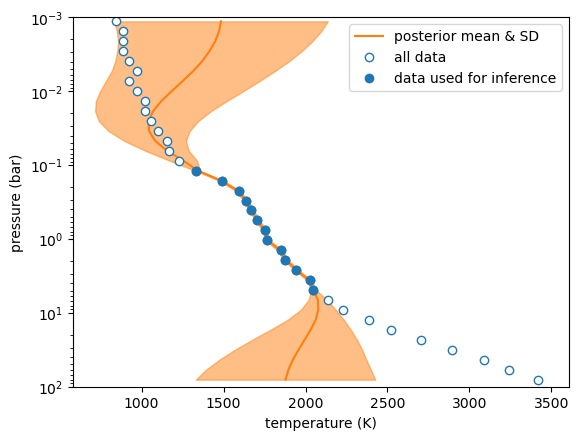

In [11]:
# does increasing max T help? -> not really
_ = run_mcmc(model_linear_t, outdir, xobs=xobs, xerr=jnp.ones_like(xobs)*sigma_t, yobs=np.log10(ytrue), data_idx=data_idx, xupp=5000, model_tag='_xupp5000')

### log T, constant mean

In [12]:
def model_log_t(xobs, xerr, yobs, data_idx, xlow=500, xupp=3500, alphamax=1e4):
    N = len(yobs)
    logmu = numpyro.sample("logmu", dist.Uniform(jnp.log10(xlow), jnp.log10(xupp)))
    logtarr = numpyro.sample("logtarr", dist.Uniform(jnp.ones(N)*jnp.log10(xlow), jnp.ones(N)*jnp.log10(xupp)))
    mu = numpyro.deterministic("mu", 10**logmu)
    tarr = numpyro.deterministic("tarr", 10**logtarr)
    numpyro.sample("obs", dist.Normal(tarr[data_idx], xerr[data_idx]), obs=xobs[data_idx])

    logtau = numpyro.sample("logtau", dist.Uniform(jnp.log10(0.3), jnp.log10(30)))
    logalpha = numpyro.sample("logalpha", dist.Uniform(jnp.log10(0.01), jnp.log10(10)))
    logsigma = numpyro.sample("logsigma", dist.Uniform(jnp.log10(0.01), jnp.log10(10)))
    tau = numpyro.deterministic("tau", 10**logtau)
    alpha = numpyro.deterministic("alpha", 10**logalpha)
    sigma = numpyro.deterministic("sigma", 10**logsigma) 
    cov_gp = cov_rbf(yobs, tau, alpha, sigma * jnp.ones(N))
    gp = dist.MultivariateNormal(loc=logmu*jnp.ones(N), covariance_matrix=cov_gp)
    loglike_gp = numpyro.deterministic("loglike_gp", gp.log_prob(logtarr))
    numpyro.factor("loglike", loglike_gp)

sample: 100%|██████████| 2000/2000 [00:24<00:00, 81.21it/s, 31 steps of size 1.09e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   logalpha     -0.47      0.41     -0.52     -1.15      0.15     72.58      1.01
      logmu      3.14      0.20      3.17      2.81      3.48    569.22      1.00
   logsigma     -1.89      0.09     -1.91     -2.00     -1.76    252.63      1.00
 logtarr[0]      3.00      0.15      2.97      2.75      3.25     87.84      1.00
 logtarr[1]      3.00      0.14      2.98      2.79      3.25     88.85      1.00
 logtarr[2]      3.01      0.13      2.99      2.80      3.22     88.53      1.00
 logtarr[3]      3.01      0.12      3.00      2.80      3.20     92.19      1.00
 logtarr[4]      3.02      0.11      3.01      2.84      3.19     91.52      1.01
 logtarr[5]      3.02      0.10      3.01      2.87      3.20     99.70      1.01
 logtarr[6]      3.03      0.09      3.02      2.90      3.19    117.87      1.01
 logtarr[7]      3.04      0.08      3.03      2.91      3.16    162.23      1.01
 logtarr[8]    

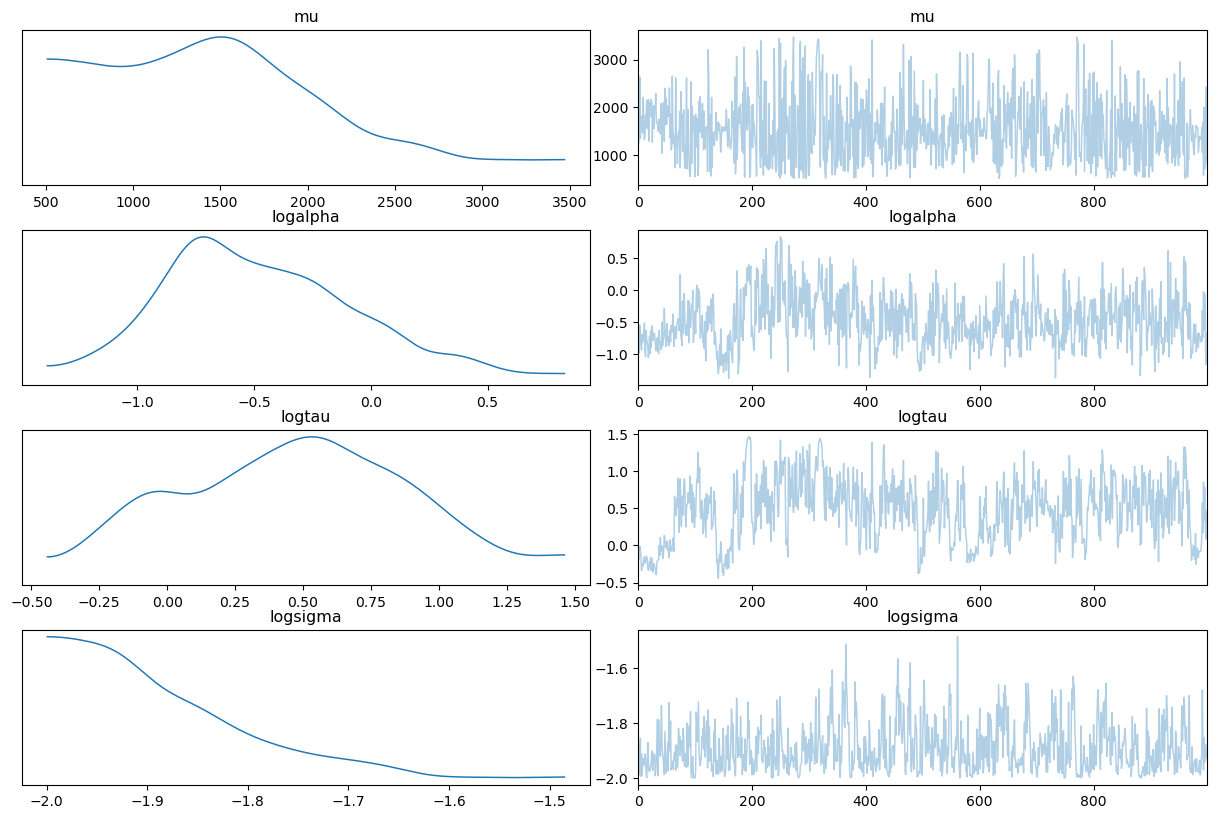

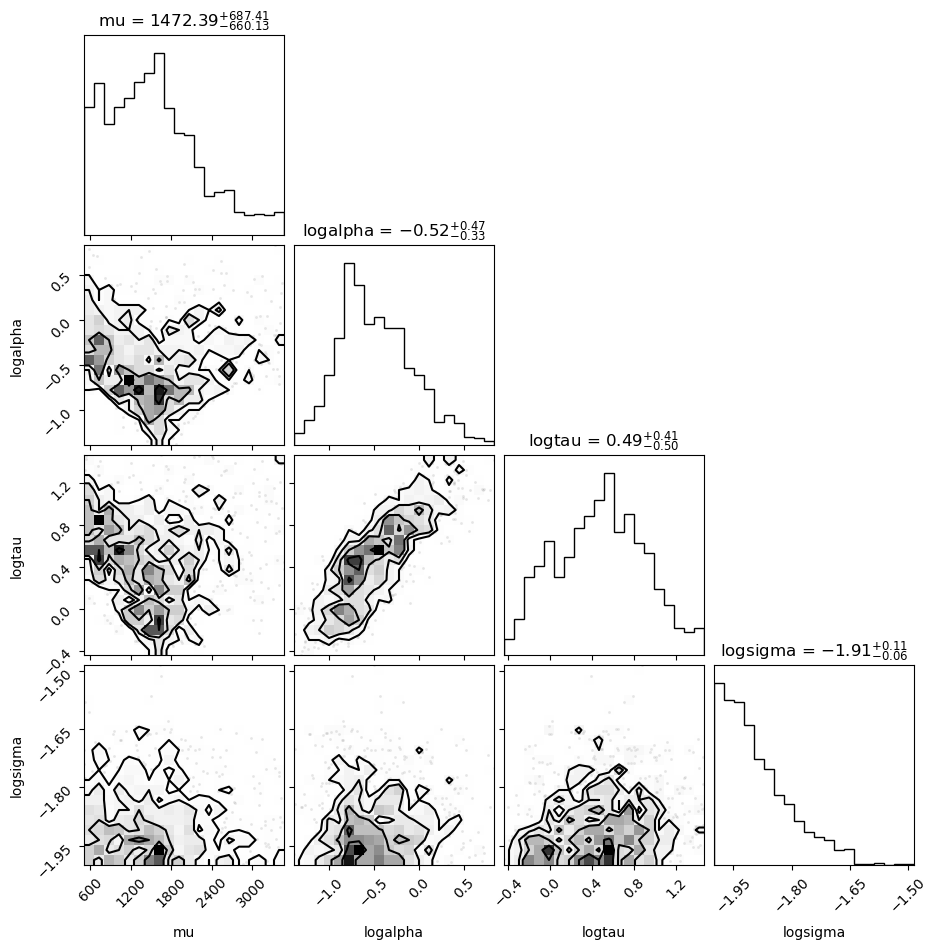

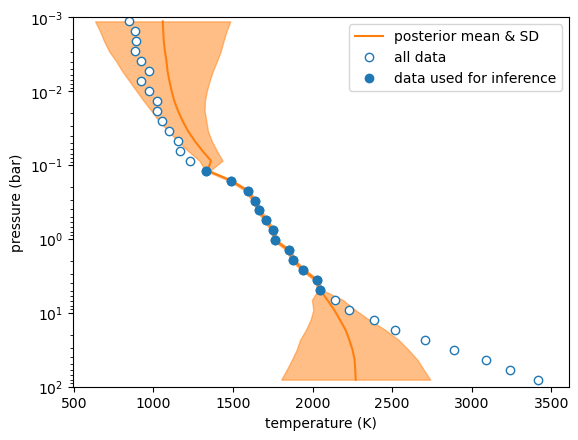

In [13]:
idata_log_t = run_mcmc(model_log_t, outdir, xobs=xobs, xerr=jnp.ones_like(xobs)*sigma_t, yobs=np.log10(ytrue), data_idx=data_idx)

### linear T, power-law mean

In [14]:
def model_linear_t_plmean(xobs, xerr, yobs, data_idx, xlow=500, xupp=3500, alphamax=1e4):
    N = len(yobs)
    tarr_base = numpyro.sample("tarr_base", dist.Uniform(jnp.zeros(N),jnp.ones(N)))
    tarr = numpyro.deterministic("tarr", tarr_base * (xupp - xlow) + xlow)
    numpyro.sample("obs", dist.Normal(tarr[data_idx], xerr[data_idx]), obs=xobs[data_idx]) 
    
    t0_base = numpyro.sample("t0_base", dist.Uniform(0, 1))
    t0 = numpyro.deterministic("t0", t0_base * (xupp - xlow) + xlow)
    a = numpyro.sample("a", dist.Uniform(0, 0.3))
    mu = numpyro.deterministic("mu", t0 * (10**yobs)**a)

    logtau = numpyro.sample("logtau", dist.Uniform(jnp.log10(0.3), jnp.log10(30)))
    logalpha = numpyro.sample("logalpha", dist.Uniform(jnp.log10(100), jnp.log10(alphamax)))
    logsigma = numpyro.sample("logsigma", dist.Uniform(jnp.log10(10), jnp.log10(1000)))
    tau = numpyro.deterministic("tau", 10**logtau)
    alpha = numpyro.deterministic("alpha", 10**logalpha)
    sigma = numpyro.deterministic("sigma", 10**logsigma)
    cov_gp = cov_rbf(yobs, tau, alpha, sigma * jnp.ones(N))
    gp = dist.MultivariateNormal(loc=mu*jnp.ones(N), covariance_matrix=cov_gp)
    loglike_gp = numpyro.deterministic("loglike_gp", gp.log_prob(tarr))
    numpyro.factor("loglike", loglike_gp)

sample: 100%|██████████| 2000/2000 [00:37<00:00, 54.02it/s, 63 steps of size 7.92e-02. acc. prob=0.81] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
            a      0.10      0.04      0.10      0.02      0.14    161.16      1.00
     logalpha      2.39      0.33      2.30      2.00      2.86     86.25      1.00
     logsigma      1.33      0.23      1.29      1.00      1.67     30.28      1.02
       logtau     -0.02      0.51     -0.23     -0.52      0.90     26.68      1.02
      t0_base      0.41      0.09      0.41      0.28      0.50    239.50      1.00
 tarr_base[0]      0.15      0.11      0.13      0.01      0.28    172.73      1.01
 tarr_base[1]      0.15      0.10      0.14      0.00      0.27    174.23      1.01
 tarr_base[2]      0.16      0.10      0.15      0.01      0.27    191.15      1.01
 tarr_base[3]      0.17      0.09      0.16      0.02      0.28    207.08      1.02
 tarr_base[4]      0.17      0.08      0.16      0.03      0.28    219.47      1.02
 tarr_base[5]      0.18      0.08      0.17      0.04      0.28    207.14  

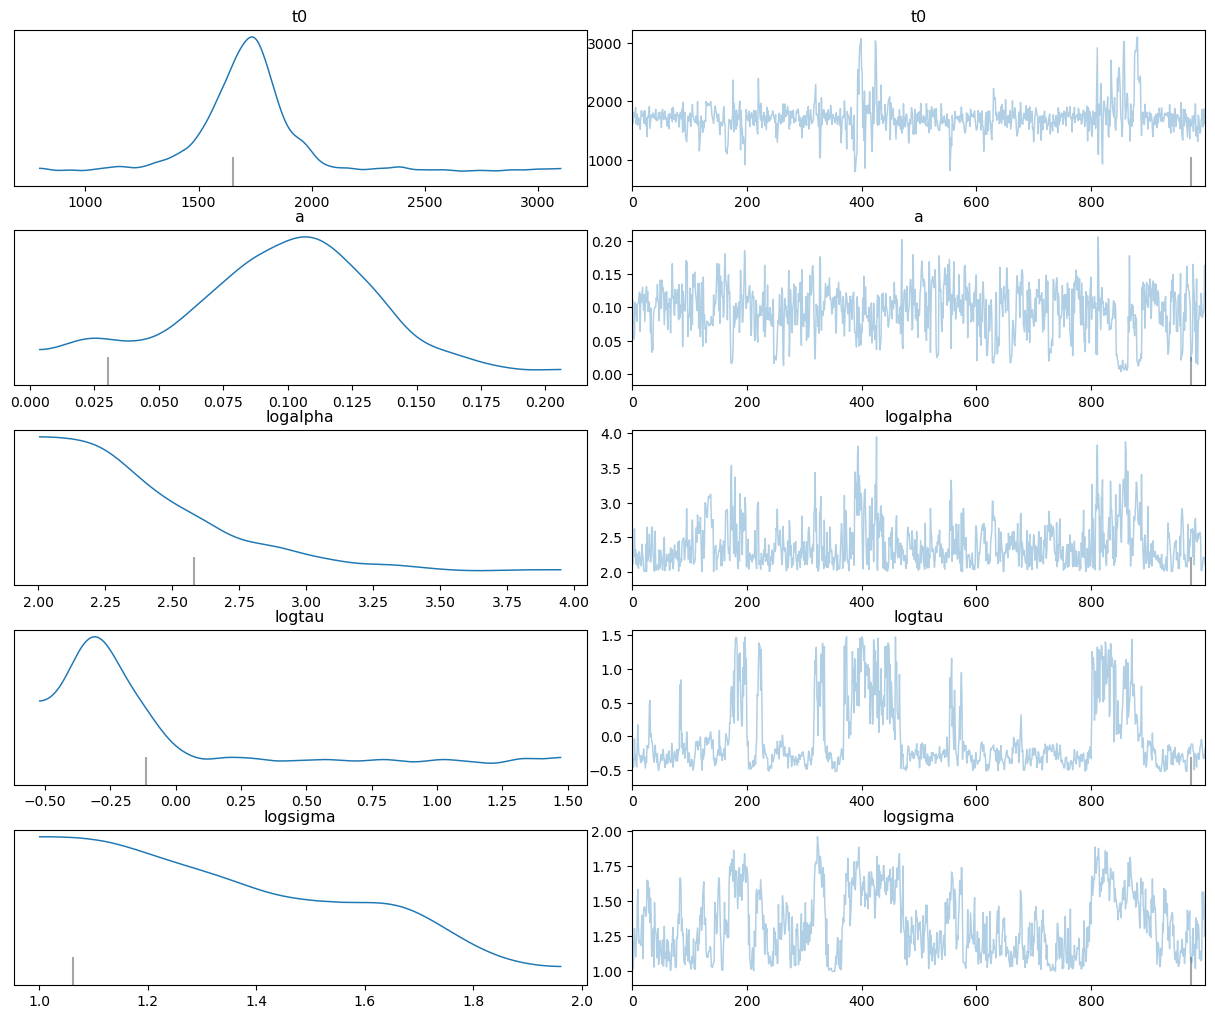

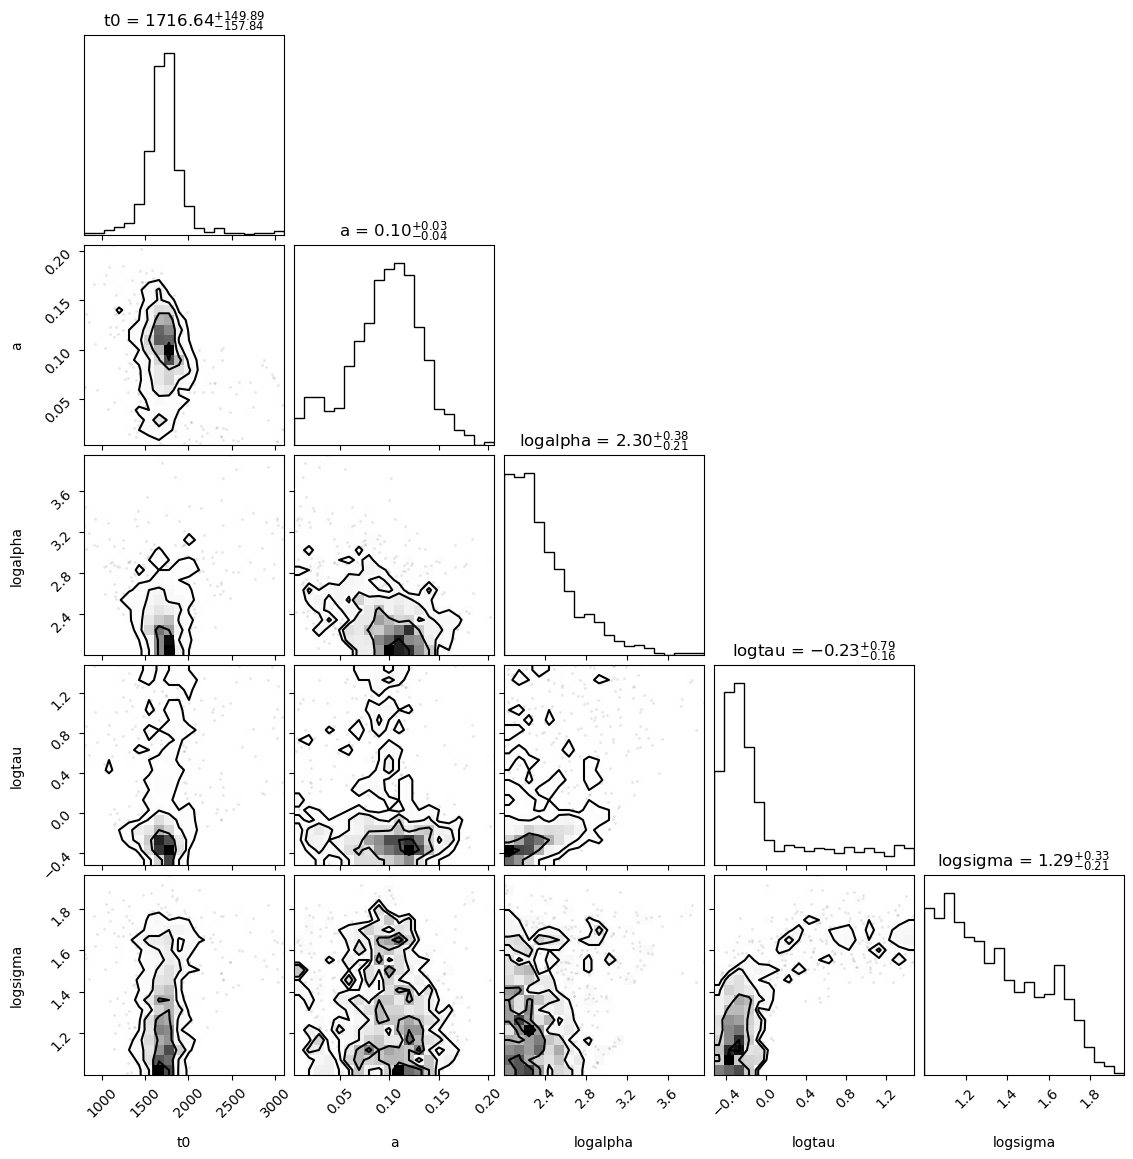

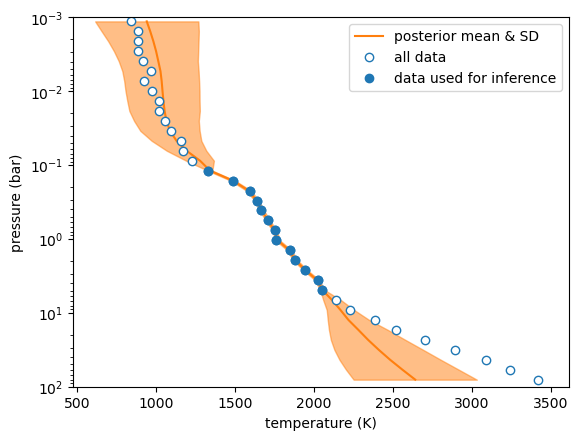

In [15]:
idata_linear_t_plmean = run_mcmc(model_linear_t_plmean, outdir, xobs=xobs, xerr=jnp.ones_like(xobs)*sigma_t, yobs=np.log10(ytrue), data_idx=data_idx)

### log T, power-law mean

In [23]:
def model_log_t_plmean(xobs, xerr, yobs, data_idx, xlow=500, xupp=3500):
    N = len(yobs)
    logtarr = numpyro.sample("logtarr", dist.Uniform(jnp.ones(N)*jnp.log10(xlow), jnp.ones(N)*jnp.log10(xupp)))
    tarr = numpyro.deterministic("tarr", 10**logtarr)
    numpyro.sample("obs", dist.Normal(tarr[data_idx], xerr[data_idx]), obs=xobs[data_idx])

    #this causes many divergences
    #logt0 = numpyro.sample('logt0', dist.Uniform(jnp.log10(xlow), jnp.log10(xupp)))
    #t0 = numpyro.deterministic("t0", 10**logt0)

    t0_base = numpyro.sample('t0_base', dist.Uniform(0, 1))
    t0 = numpyro.deterministic("t0", t0_base * (xupp - xlow) + xlow)
    logt0 = numpyro.deterministic("logt0", jnp.log10(t0))

    a = numpyro.sample("a", dist.Uniform(0, 0.3))
    logmu = numpyro.deterministic("logmu", logt0 + a * yobs)
    mu = numpyro.deterministic("mu", 10**logmu)

    logtau = numpyro.sample("logtau", dist.Uniform(jnp.log10(0.3), jnp.log10(30)))
    logalpha = numpyro.sample("logalpha", dist.Uniform(jnp.log10(0.01), jnp.log10(10)))
    logsigma = numpyro.sample("logsigma", dist.Uniform(jnp.log10(0.01), jnp.log10(10)))
    tau = numpyro.deterministic("tau", 10**logtau)
    alpha = numpyro.deterministic("alpha", 10**logalpha)
    sigma = numpyro.deterministic("sigma", 10**logsigma) 
    cov_gp = cov_rbf(yobs, tau, alpha, sigma * jnp.ones(N))
    gp = dist.MultivariateNormal(loc=logmu, covariance_matrix=cov_gp)
    loglike_gp = numpyro.deterministic("loglike_gp", gp.log_prob(logtarr))
    numpyro.factor("loglike", loglike_gp)

sample: 100%|██████████| 2000/2000 [00:51<00:00, 39.02it/s, 127 steps of size 4.50e-02. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.11      0.04      0.10      0.04      0.16    302.64      1.00
   logalpha     -1.14      0.56     -1.23     -2.00     -0.41    159.65      1.01
   logsigma     -1.88      0.09     -1.90     -2.00     -1.76    364.69      1.00
 logtarr[0]      2.93      0.07      2.94      2.81      3.04    244.92      1.00
 logtarr[1]      2.94      0.07      2.96      2.82      3.04    224.96      1.00
 logtarr[2]      2.96      0.07      2.97      2.84      3.05    217.08      1.00
 logtarr[3]      2.97      0.06      2.98      2.86      3.05    190.47      1.00
 logtarr[4]      2.99      0.06      3.00      2.88      3.07    171.76      1.00
 logtarr[5]      3.00      0.05      3.01      2.91      3.07    161.18      1.00
 logtarr[6]      3.01      0.05      3.03      2.92      3.08    149.98      1.00
 logtarr[7]      3.03      0.05      3.04      2.95      3.10    141.53      1.00
 logtarr[8]    

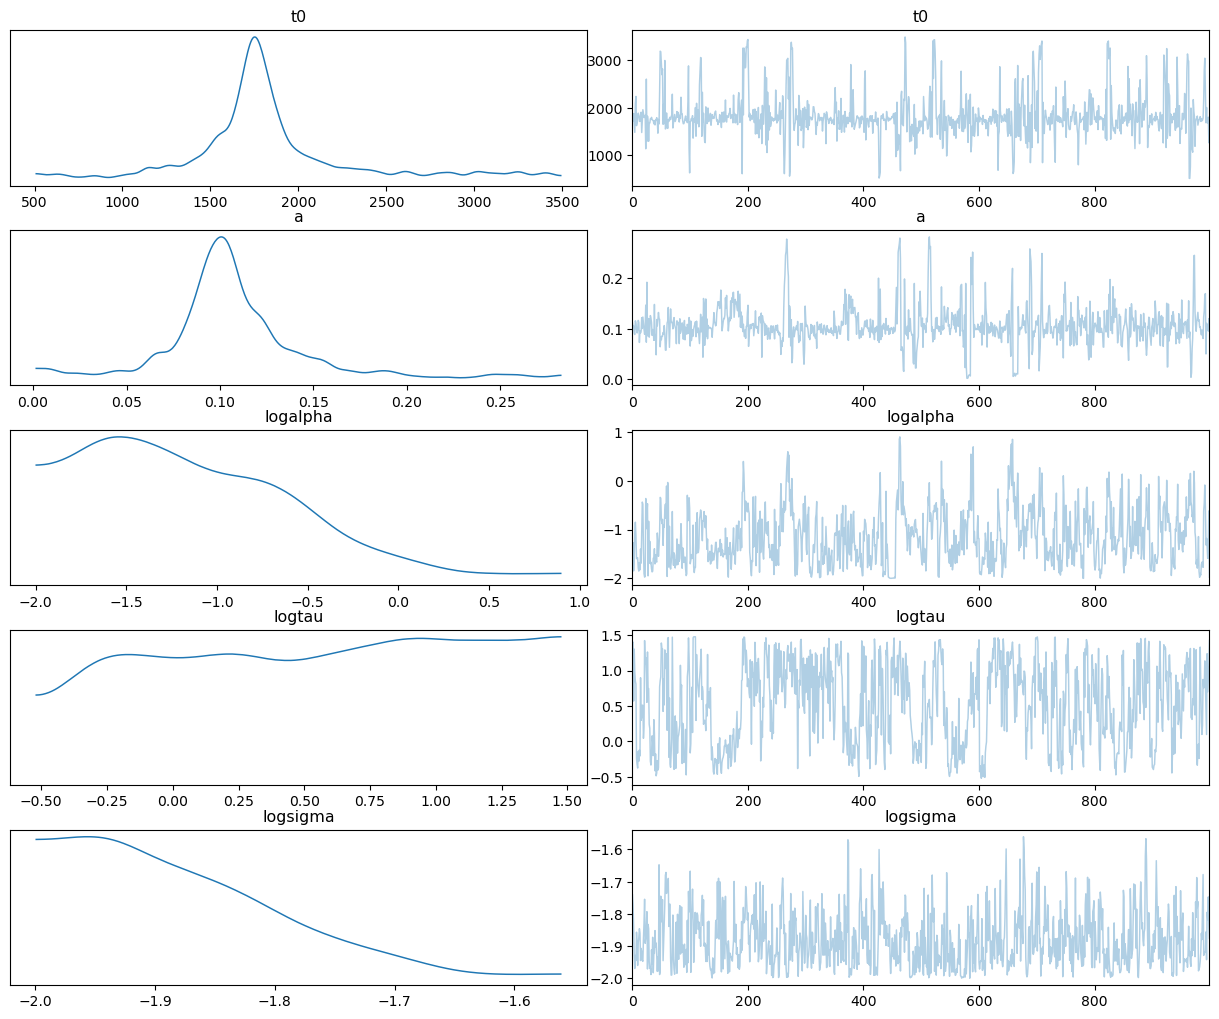

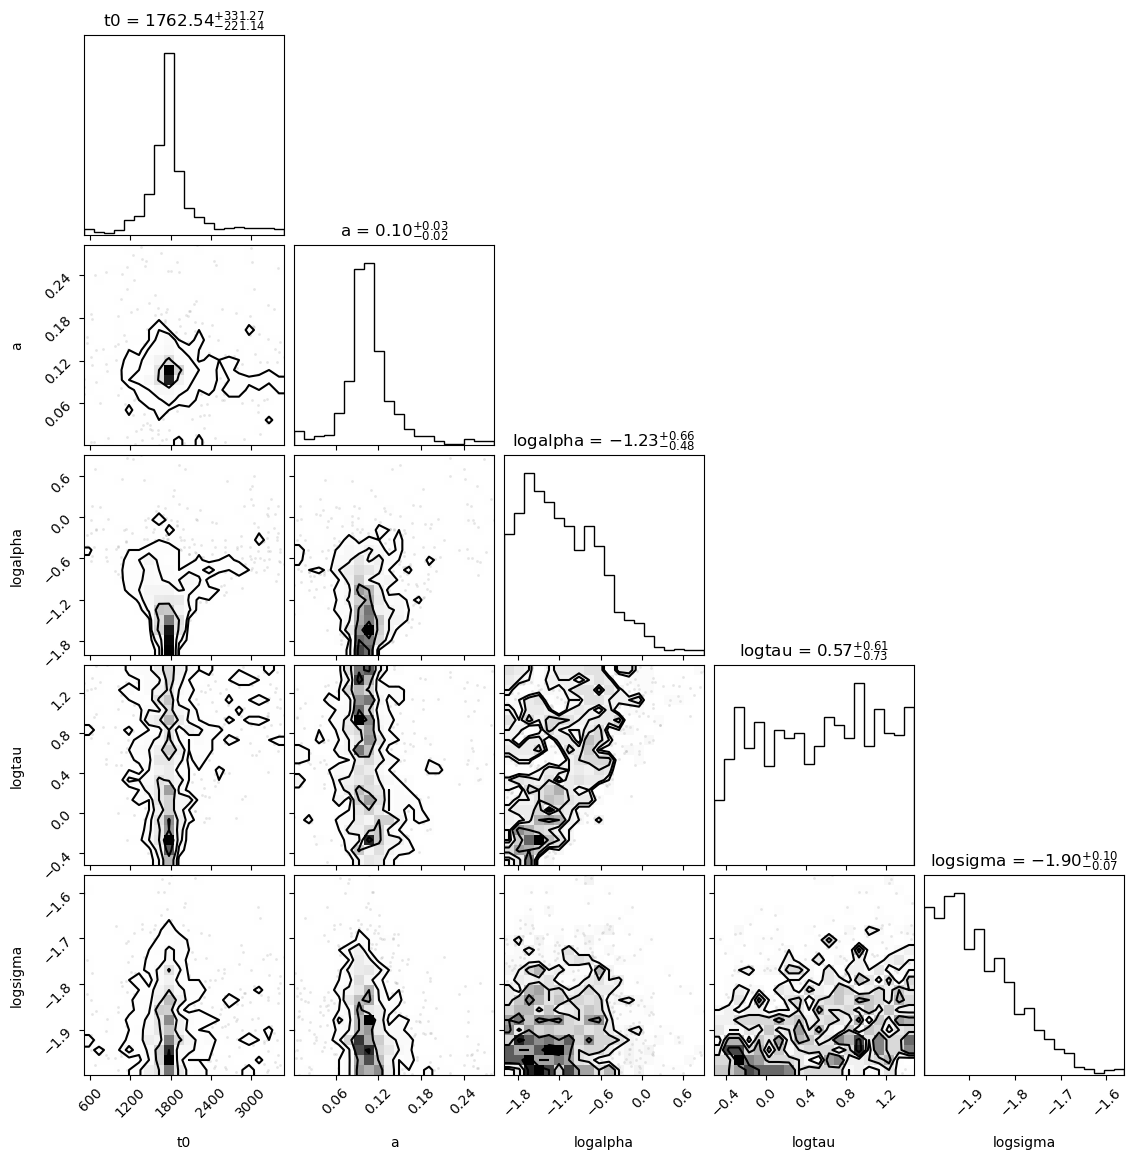

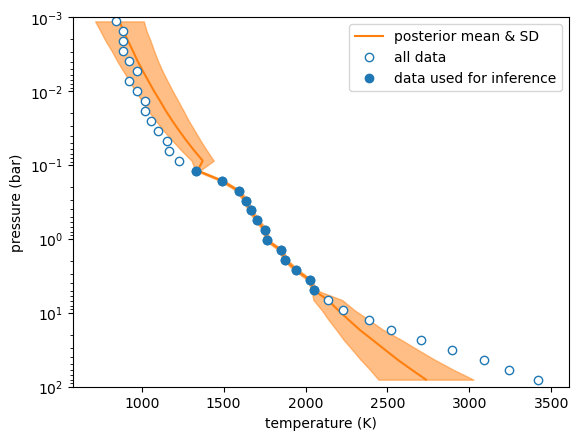

In [24]:
idata_log_t_plmean = run_mcmc(model_log_t_plmean, outdir, xobs=xobs, xerr=jnp.ones_like(xobs)*sigma_t, yobs=np.log10(ytrue), data_idx=data_idx)

### log T, power-law mean, direct sampling from MvN

In [25]:
def model_log_t_plmean_direct(xobs, xerr, yobs, data_idx, xlow=500, xupp=3500):
    N = len(yobs)
    
    #this causes many divergences
    #logt0 = numpyro.sample('logt0', dist.Uniform(jnp.log10(xlow), jnp.log10(xupp)))
    #t0 = numpyro.deterministic("t0", 10**logt0)

    t0_base = numpyro.sample('t0_base', dist.Uniform(0, 1))
    t0 = numpyro.deterministic("t0", t0_base * (xupp - xlow) + xlow)
    logt0 = numpyro.deterministic("logt0", jnp.log10(t0))

    a = numpyro.sample("a", dist.Uniform(0, 0.3))
    logmu = numpyro.deterministic("logmu", logt0 + a * yobs)
    mu = numpyro.deterministic("mu", 10**logmu)

    logtau = numpyro.sample("logtau", dist.Uniform(jnp.log10(0.3), jnp.log10(30)))
    logalpha = numpyro.sample("logalpha", dist.Uniform(jnp.log10(0.01), jnp.log10(10)))
    logsigma = numpyro.sample("logsigma", dist.Uniform(jnp.log10(0.01), jnp.log10(10)))
    tau = numpyro.deterministic("tau", 10**logtau)
    alpha = numpyro.deterministic("alpha", 10**logalpha)
    sigma = numpyro.deterministic("sigma", 10**logsigma) 
    cov_gp = cov_rbf(yobs, tau, alpha, sigma * jnp.ones(N))
    gp = dist.MultivariateNormal(loc=logmu, covariance_matrix=cov_gp)

    logtarr = numpyro.sample("logtarr", gp)
    tarr = numpyro.deterministic("tarr", 10**logtarr)
    numpyro.sample("obs", dist.Normal(tarr[data_idx], xerr[data_idx]), obs=xobs[data_idx])

sample: 100%|██████████| 2000/2000 [02:31<00:00, 13.21it/s, 127 steps of size 1.99e-02. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.12      0.05      0.11      0.05      0.21    142.09      1.01
   logalpha     -1.17      0.55     -1.23     -2.00     -0.44     93.51      1.01
   logsigma     -1.89      0.09     -1.91     -2.00     -1.76    184.32      1.01
 logtarr[0]      2.89      0.15      2.94      2.66      3.09    148.14      1.01
 logtarr[1]      2.91      0.14      2.95      2.67      3.08    148.42      1.01
 logtarr[2]      2.92      0.14      2.96      2.68      3.08    143.88      1.01
 logtarr[3]      2.94      0.13      2.98      2.72      3.10    145.36      1.01
 logtarr[4]      2.96      0.12      2.99      2.75      3.10    139.00      1.01
 logtarr[5]      2.97      0.11      3.01      2.79      3.10    138.02      1.01
 logtarr[6]      2.99      0.10      3.02      2.82      3.11    130.18      1.01
 logtarr[7]      3.01      0.09      3.03      2.85      3.12    129.81      1.00
 logtarr[8]    

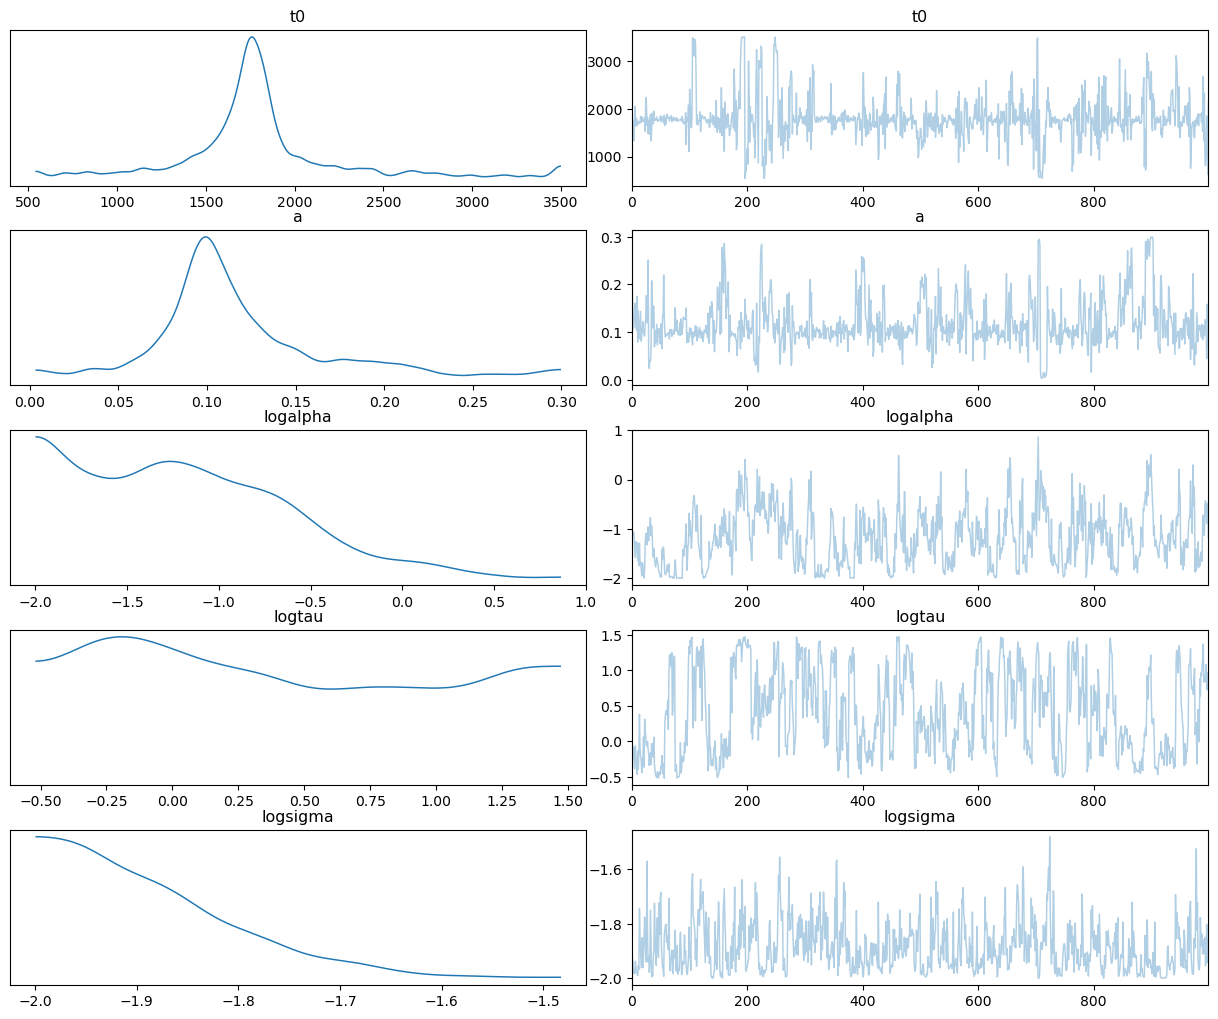

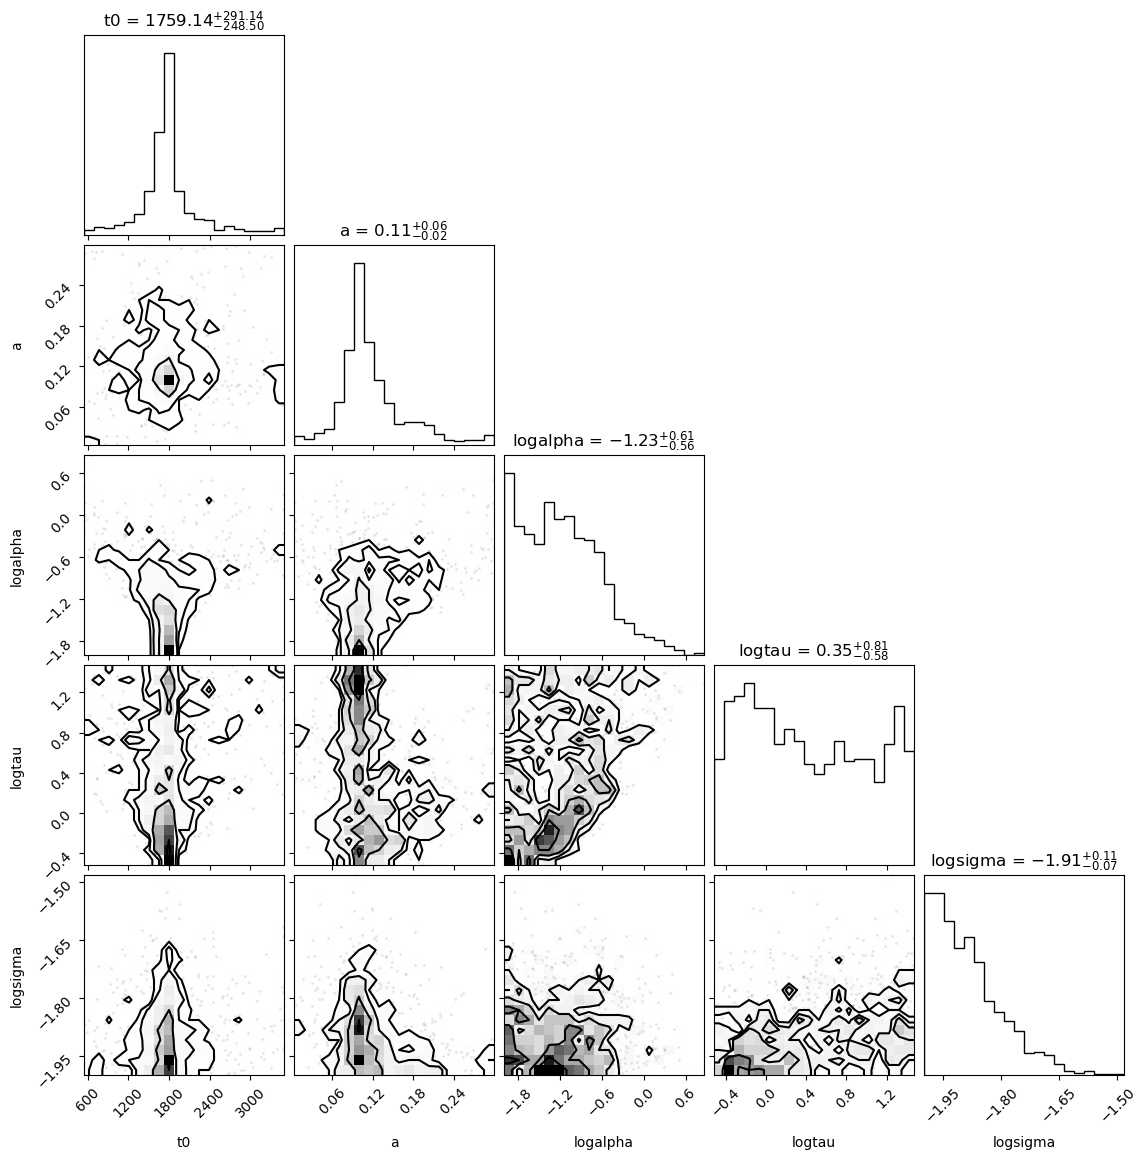

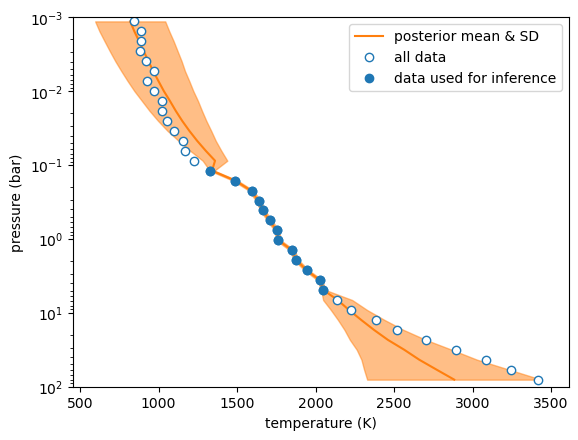

In [26]:
idata_log_t_plmean_direct = run_mcmc(model_log_t_plmean_direct, outdir, xobs=xobs, xerr=jnp.ones_like(xobs)*sigma_t, yobs=np.log10(ytrue), data_idx=data_idx)